In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import gc  # Garbage collector to help manage memory

In [2]:
# Path to the file
file_path = '20250314_085258--2324611--2324910.npy'

# First, check the file size
file_size_gb = os.path.getsize(file_path) / (1024 ** 3)
print(f"File size: {file_size_gb:.2f} GB")

File size: 13.90 GB


In [3]:
# 1. Investigate shape and datatype using numpy.lib.format
# This allows getting metadata without loading the entire array
with open(file_path, 'rb') as f:
    version = np.lib.format.read_magic(f)
    shape, fortran_order, dtype = np.lib.format.read_array_header_1_0(f)
    
print(f"Array shape: {shape}")
print(f"Data type: {dtype}")
print(f"Fortran order: {fortran_order}")

Array shape: (300, 1080, 1920, 3)
Data type: float64
Fortran order: False


In [4]:
# Calculate number of elements and memory usage
num_elements = np.prod(shape)
element_size = np.dtype(dtype).itemsize
total_size_gb = (num_elements * element_size) / (1024**3)

print(f"Number of elements: {num_elements}")
print(f"Element size: {element_size} bytes")
print(f"Calculated size: {total_size_gb:.2f} GB")

Number of elements: 1866240000
Element size: 8 bytes
Calculated size: 13.90 GB


In [8]:
# Function to load a specific frame from the file without loading the entire array
def load_specific_frame(file_path, frame_idx):
    # We'll use np.load with mmap_mode to avoid loading the entire array
    mmap_data = np.load(file_path, mmap_mode='r')
    
    # Extract just the frame we want
    single_frame = mmap_data[frame_idx].copy()  # .copy() to get it out of mmap
    
    # Close the mmap to free resources
    mmap_data._mmap.close()
    del mmap_data
    gc.collect()
    
    return single_frame

In [36]:
def get_plot_limits(data, percentile_min=1, percentile_max=99):
    """
    Calculate appropriate plot limits for data visualization.
    
    Args:
        data (ndarray): Input image data
        percentile_min (int): Lower percentile to use for vmin
        percentile_max (int): Upper percentile to use for vmax
        
    Returns:
        tuple: (vmin, vmax) values for plotting
    """
    vmin, vmax = None, None
    if np.issubdtype(data.dtype, np.floating):
        if data.max() > 1.0 or data.min() < 0.0:
            vmin = np.percentile(data, percentile_min)
            vmax = np.percentile(data, percentile_max)
    return vmin, vmax


def add_stat_annotations(ax, data, text_color='white', bg_color='black', fontsize=9):
    """
    Add statistical annotations to a plot.
    
    Args:
        ax: Matplotlib axes object
        data (ndarray): Image data to calculate stats from
        text_color (str): Color of annotation text
        bg_color (str): Background color for annotations
        fontsize (int): Font size for annotations
    """
    stats = {
        'Min': data.min(),
        'Max': data.max(),
        'Mean': data.mean()
    }
    
    y_pos = 0.95
    for label, value in stats.items():
        ax.text(0.05, y_pos, f"{label}: {value:.2f}", 
                transform=ax.transAxes,
                color=text_color, 
                fontweight='bold', 
                backgroundcolor=bg_color, 
                fontsize=fontsize)
        y_pos -= 0.1


def calculate_figure_dimensions(aspect_ratio=16/9, width=None, height_factor=0.6):
    """
    Calculate appropriate figure dimensions.
    
    Args:
        aspect_ratio (float): Desired aspect ratio (width/height)
        width (float): Base width (if None, defaults based on use case)
        height_factor (float): Factor to adjust height
        
    Returns:
        tuple: (width, height) for the figure
    """
    if width is None:
        width = 16  # default width
    height = width / aspect_ratio * height_factor
    return width, height


def visualize_single_band(data, title, ax=None, cmap='viridis', percentiles=(1, 99)):
    """
    Visualize a single band of data.
    
    Args:
        data (ndarray): 2D image data
        title (str): Title for the subplot
        ax: Matplotlib axes (if None, current axes will be used)
        cmap (str): Colormap name
        percentiles (tuple): Percentiles for color scaling
    
    Returns:
        The image object created by imshow
    """
    if ax is None:
        ax = plt.gca()
    
    vmin, vmax = get_plot_limits(data, percentiles[0], percentiles[1])
    im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('on')
    
    # Add statistical annotations
    add_stat_annotations(ax, data)
    
    return im


def visualize_frame(frame, title, aspect_ratio=16/9, height_factor=0.4, cmap='viridis',
                   percentiles=(1, 99), band_names=None):
    """
    Visualize a multi-dimensional frame with individual bands.
    
    Args:
        frame (ndarray): Input image data
        title (str): Main title for the figure
        aspect_ratio (float): Desired aspect ratio
        height_factor (float): Factor to adjust height
        cmap (str): Colormap for visualization
        percentiles (tuple): Percentiles for color scaling
        band_names (list): Custom names for bands (default: None)
    """
    # Handle different data shapes
    if len(frame.shape) == 3 and frame.shape[2] >= 1:
        # Multi-band image
        num_bands = min(3, frame.shape[2])
        
        # Set default band names if not provided
        if band_names is None:
            band_names = ['Red', 'Green', 'Blue'] if num_bands == 3 else [f'Band {i+1}' for i in range(num_bands)]
        
        # Calculate figure dimensions
        width, height = calculate_figure_dimensions(aspect_ratio, width=16, height_factor=height_factor)
        
        # Create figure with subplots
        fig, axes = plt.subplots(1, num_bands, figsize=(width, height))
        fig.suptitle(title, fontsize=16)
        
        # Handle case when only one band (axes would not be array)
        if num_bands == 1:
            axes = [axes]
        
        # Visualize each band
        for i in range(num_bands):
            band = frame[:, :, i]
            im = visualize_single_band(band, band_names[i], axes[i], cmap, percentiles)
            fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
            
    elif len(frame.shape) == 2:
        # Single grayscale image
        width, height = calculate_figure_dimensions(aspect_ratio, width=12, height_factor=height_factor)
        fig = plt.figure(figsize=(width, height))
        
        im = visualize_single_band(frame, title, plt.gca(), cmap, percentiles)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        
    elif len(frame.shape) == 3 and frame.shape[2] == 1:
        # 3D array with single channel
        frame_2d = frame[:, :, 0]
        
        width, height = calculate_figure_dimensions(aspect_ratio, width=12, height_factor=height_factor)
        fig = plt.figure(figsize=(width, height))
        
        im = visualize_single_band(frame_2d, title, plt.gca(), cmap, percentiles)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        
    else:
        print(f"Unsupported frame shape: {frame.shape}")
        return
    
    plt.tight_layout()
    plt.show()

In [37]:
# 2. Visualize a subset of frames - first frame from each of `num_segments` parts
def visualize_subset_frames(file_path, num_segments=10):
    # Use mmap to get shape without loading entire array
    mmap_data = np.load(file_path, mmap_mode='r')
    total_frames = mmap_data.shape[0]
    frame_shape = mmap_data.shape[1:]
    
    print(f"Dataset info:")
    print(f"- Total frames: {total_frames}")
    print(f"- Frame dimensions: {frame_shape}")
    if len(frame_shape) == 3:
        print(f"- Frame aspect ratio: {frame_shape[1]/frame_shape[0]:.2f}")
        print(f"- Number of channels: {frame_shape[2]}")
    
    # Calculate sampling points across `num_segments` segments
    frame_indices = [int(i * total_frames / num_segments) for i in range(num_segments)]
    print(f"Sampling frames at indices: {frame_indices}")
    
    # Close mmap to free resources before proceeding
    mmap_data._mmap.close()
    del mmap_data
    gc.collect()
    
    # Now load and visualize each sampled frame
    for i, frame_idx in enumerate(frame_indices):
        print(f"\nLoading frame {frame_idx} (segment {i+1}/{num_segments})")
        try:
            frame = load_specific_frame(file_path, frame_idx)
            visualize_frame(frame, f"Frame {frame_idx} (segment {i+1}/{num_segments})")
            
            # Clean up to ensure memory is freed
            del frame
            gc.collect()
            
            # Optional: pause between visualizations to inspect each one
            # if i < len(frame_indices) - 1:
            #     resp = input("Press Enter to continue to next frame (or 'q' to quit): ")
            #     if resp.lower() == 'q':
            #         break
                
        except Exception as e:
            print(f"Error visualizing frame {frame_idx}: {e}")

Dataset info:
- Total frames: 300
- Frame dimensions: (1080, 1920, 3)
- Frame aspect ratio: 1.78
- Number of channels: 3
Sampling frames at indices: [0, 60, 120, 180, 240]

Loading frame 0 (segment 1/5)


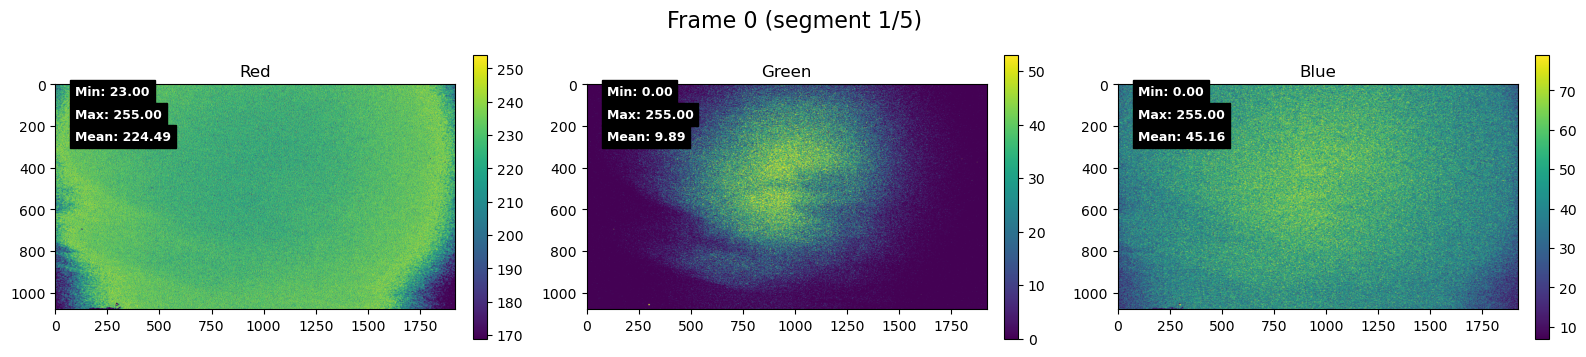


Loading frame 60 (segment 2/5)


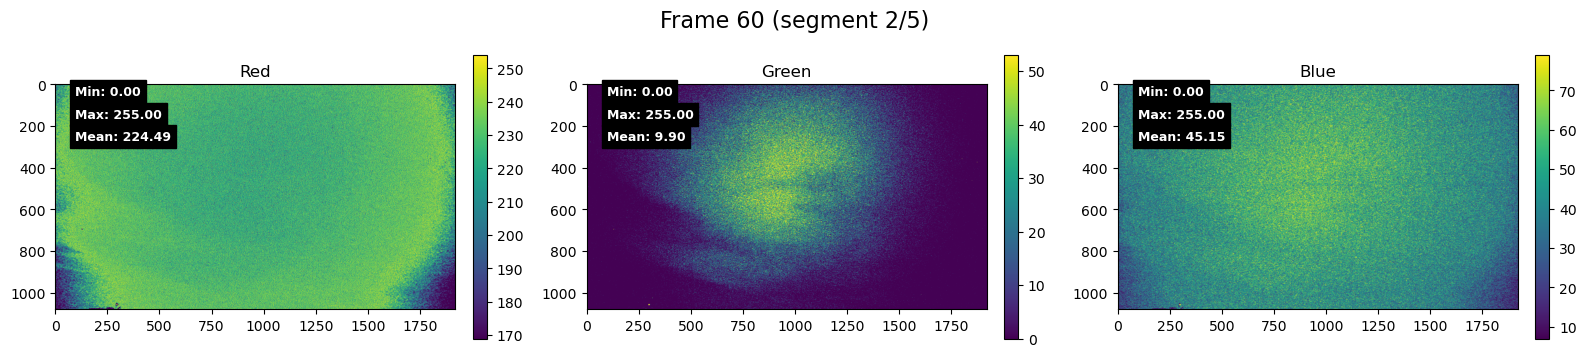


Loading frame 120 (segment 3/5)


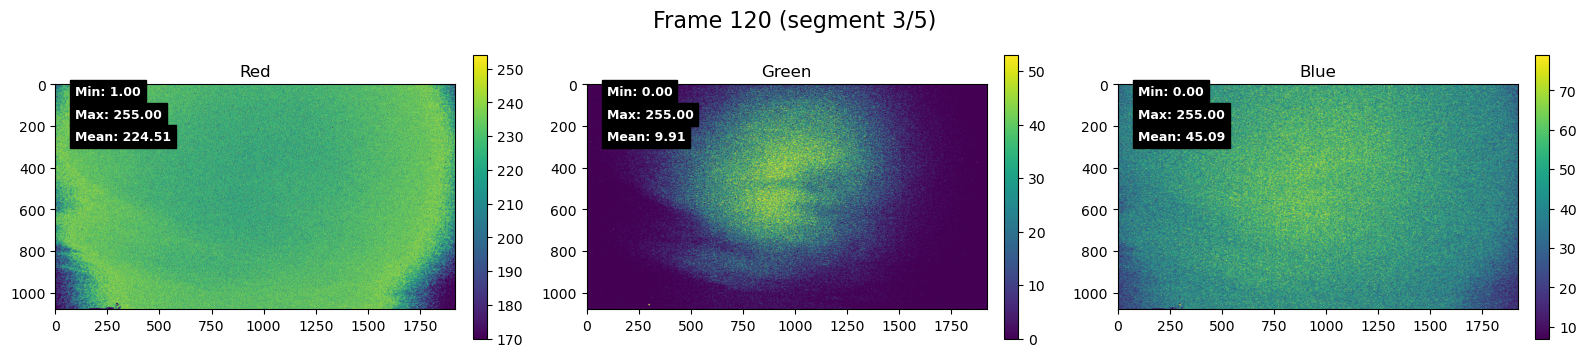


Loading frame 180 (segment 4/5)


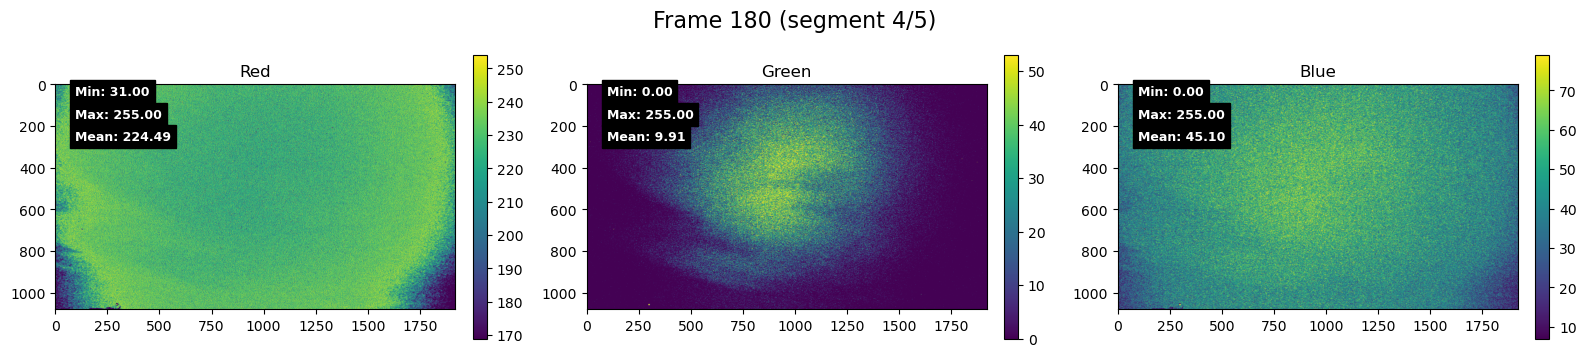


Loading frame 240 (segment 5/5)


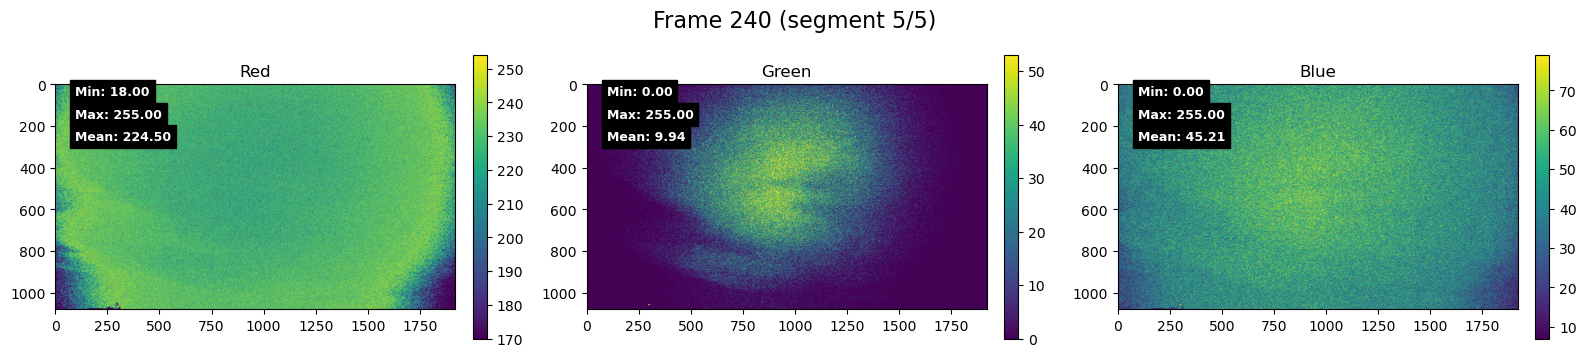

In [38]:
# Run the visualization
visualize_subset_frames(file_path, num_segments=5)